In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

## Load data

In [85]:
# Function to read a CSV file for a given stock and date
def read_csv_file(stock, date):
    dt = datetime.strptime(date, "%Y%m%d")
    year = dt.year
    month = dt.month

    def get_last_thursday(y, m):
        if m == 12:
            last_day = datetime(y + 1, 1, 1) - timedelta(days=1)
        else:
            last_day = datetime(y, m + 1, 1) - timedelta(days=1)
        offset = (last_day.weekday() - 3) % 7  # Thursday is 3
        return last_day - timedelta(days=offset)

    last_thurs_current = get_last_thursday(year, month)

    # If last Thursday of current month is before the input date,
    # get last Thursday of next month
    if last_thurs_current < dt:
        # increment month/year for next month
        if month == 12:
            next_month = 1
            next_year = year + 1
        else:
            next_month = month + 1
            next_year = year
        last_thurs = get_last_thursday(next_year, next_month)
    else:
        last_thurs = last_thurs_current

    last_thurs_str = last_thurs.strftime("%Y%m%d")

    file_path = f"{stock}/{year}/{year}_new/{stock}_{date}_{last_thurs_str}_Intraday_Preprocessed.csv"

    try:
        return pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None

## Backtesting function

In [136]:
def simulate_hedged_straddle_day(
    raw_stock_dfs,        # List of S_i dataframes instead of preprocessed df_all_stocks
    stocks,
    weights,
    start_date,
    hedge_interval_minutes,
    r,
    dividend_yield,
    initial_cash
):
    """
    Simulate daily hedging of ATM straddle portfolio with H1 hedging strategy.

    Returns:
    - pnl_df: DataFrame with PnL and cash evolution indexed by time
    - total_value: final portfolio value after closing all positions
    - final_report: dict with additional info like losses on ITM options and cash
    """
    # Preprocess the raw stock dataframes
    processed_dfs = []
    for df in raw_stock_dfs:
        df = df.rename(columns={'Date Time': 'Timestamp'})
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])

        # Extract stock name from Instrument column
        instrument_sample = df['Instrument'].iloc[0]
        stock_name = instrument_sample.split()[0]  # Or adjust based on format
        df['Stock'] = stock_name

        processed_dfs.append(df)

    # Combine and format
    df_all_stocks = pd.concat(processed_dfs, ignore_index=True)
    df_all_stocks.set_index(['Timestamp', 'Stock', 'Strike', 'Type'], inplace=True)
    df_all_stocks = df_all_stocks.sort_index()
    
    start_time = datetime.strptime(start_date + " 09:15", "%Y%m%d %H:%M")
    end_time = datetime.strptime(start_date + " 15:15", "%Y%m%d %H:%M")

    df_all_stocks = df_all_stocks.sort_index()

    # If input is dict of dfs per stock, combine them into one MultiIndex df
    if isinstance(df_all_stocks, dict):
        df_list = []
        for stock in stocks:
            df = df_all_stocks[stock].copy()
            df['Stock'] = stock
            df_list.append(df)
        df = pd.concat(df_list)
        df.set_index(['Timestamp', 'Stock', 'Strike', 'Type'], inplace=True)
    else:
        df = df_all_stocks.copy()
        # Ensure index levels are correct and sorted
        df = df.sort_index()

    # Filter stocks and times
    df = df.loc[(slice(start_time, end_time), stocks, slice(None), slice(None)), :]

    # Hedge times spaced by hedge_interval_minutes
    all_times = df.index.get_level_values(0).unique()
    hedge_times = [t for t in all_times if (t - start_time).seconds % (hedge_interval_minutes * 60) == 0 and start_time <= t <= end_time]

    cash = initial_cash 
    hedge_positions = {stock: 0.0 for stock in stocks}  # futures positions per stock
    option_positions = {stock: 0.0 for stock in stocks}  # number of straddle contracts sold
    option_costs = {stock: 0.0 for stock in stocks}  # initial premiums collected per stock

    pnl_records = []

    for idx, current_time in enumerate(hedge_times):
        option_values = []
        total_deltas = []

        for stock, weight in zip(stocks, weights):
            try:
                df_stock = df.loc[(current_time, stock)]
            except KeyError:
                option_values.append(0.0)
                total_deltas.append(0.0)
                continue

            # Find ATM strike closest to spot
            # df_stock has index levels ['Strike', 'Type'] after slicing Timestamp and Stock

            spot = df_stock['Spot'].iloc[0]  # spot price same for all strikes at this time

            strikes = df_stock.index.get_level_values('Strike').unique()
            # Find ATM strike closest to spot
            atm_strike = min(strikes, key=lambda x: abs(x - spot))

            # Select only rows with atm_strike
            df_atm = df_stock.loc[atm_strike]

            # df_atm now indexed by 'Type', get CE and PE rows
            ce_row = df_atm.loc[['CE']] if 'CE' in df_atm.index else None
            pe_row = df_atm.loc[['PE']] if 'PE' in df_atm.index else None

            if ce_row is None or pe_row is None:
                # handle missing case
                continue

            ce_price = float(ce_row['mid_price'].iloc[0])
            pe_price = float(pe_row['mid_price'].iloc[0])

            straddle_value = ce_price + pe_price

            ce_delta = float(ce_row['Delta'].iloc[0])
            pe_delta = float(pe_row['Delta'].iloc[0])
            straddle_delta = ce_delta + pe_delta

            # Initial sell of straddle
            if idx == 0:
                option_positions[stock] = weight / straddle_value
                option_costs[stock] = option_positions[stock] * straddle_value
                hedge_positions[stock] = 0.0
                cash += option_costs[stock]

            # Hedge trade qty
            hedge_trade_qty = -straddle_delta * option_positions[stock] - hedge_positions[stock]

            # Hedge trade at spot price
            cash -= hedge_trade_qty * spot

            # Update hedge position
            hedge_positions[stock] += hedge_trade_qty

            current_option_value = straddle_value * option_positions[stock]
            total_delta = straddle_delta * option_positions[stock] + hedge_positions[stock]

            option_values.append(current_option_value)
            total_deltas.append(total_delta)

        hedge_value = 0.0
        for stock in stocks:
            try:
                spot_price = df.loc[(current_time, stock, atm_strike, 'CE'), 'Spot']
            except KeyError:
                # If exact key not found, try to find closest strike at the current time and stock
                try:
                    partial_df = df.loc[(current_time, stock)]
                    strikes_available = partial_df.index.get_level_values('Strike').unique()
                    # Find closest strike to atm_strike
                    closest_strike = min(strikes_available, key=lambda x: abs(x - atm_strike))
                    spot_price = df.loc[(current_time, stock, closest_strike, 'CE'), 'Spot']
                except Exception:
                    # If still fails, set spot_price = 0 or np.nan (decide what fits your logic)
                    spot_price = 0.0
            hedge_value += hedge_positions[stock] * spot_price
        option_value_total = sum(option_values)
        total_portfolio_value = option_value_total + hedge_value + cash

        pnl_records.append({
            "Timestamp": current_time,
            "OptionValue": option_value_total,
            "HedgeValue": hedge_value,
            "Cash": cash,
            "TotalValue": total_portfolio_value
        })

    # End of day unwind hedge
    final_time = hedge_times[-1]
    for stock in stocks:
        spot = df.loc[(final_time, stock)]
        # Pick ATM strike to get spot price for hedging
        atm_strike = min(df.loc[(final_time, stock)].index.get_level_values('Strike'), key=lambda x: abs(x - spot['Spot'].iloc[0]))
        spot_price = df.loc[(final_time, stock, atm_strike, 'CE'), 'Spot']
        cash += hedge_positions[stock] * float(spot_price)
        hedge_positions[stock] = 0.0

    # Calculate loss from ITM short options at expiry (intrinsic value)
    total_itm_loss = 0.0
    for stock in stocks:
        df_final = df.loc[(final_time, stock)]
        atm_strikes = df_final.index.get_level_values('Strike').unique()
        for strike in atm_strikes:
            ce_row = df_final[(df_final.index.get_level_values('Type') == 'CE') & (df_final.index.get_level_values('Strike') == strike)]
            pe_row = df_final[(df_final.index.get_level_values('Type') == 'PE') & (df_final.index.get_level_values('Strike') == strike)]

            if ce_row.empty or pe_row.empty:
                continue

            spot = float(ce_row['Spot'].iloc[0])
            strike_val = float(strike)

            ce_intrinsic = max(0, spot - strike_val)
            pe_intrinsic = max(0, strike_val - spot)

            # Total intrinsic loss on straddle = (CE + PE) * number of contracts sold
            straddle_intrinsic_loss = (ce_intrinsic + pe_intrinsic) * option_positions[stock]
            total_itm_loss += straddle_intrinsic_loss
            cash -= straddle_intrinsic_loss

    total_value = cash

    pnl_df = pd.DataFrame(pnl_records).set_index('Timestamp')

    final_report = {
        "Total_ITM_Option_Loss": total_itm_loss,
        "Final_Cash": cash,
        "Final_Portfolio_Value": total_value
    }

    return pnl_df, total_value, final_report

## Use case

In [145]:
hedge_intervals = 5 # hedge interval in minutes
weight = [0.5,0.5] # weights for the two assets
stocks = ["BAJAJ-AUTO", "BAJFINANCE"] # Stock symbols
start_date = "20240403"

In [146]:
S_1 = read_csv_file(stocks[0], start_date)
S_2 = read_csv_file(stocks[1], start_date)

In [150]:
S_1.columns

Index(['Date Time', 'ExchToken', 'BidPrice', 'BidQty', 'AskPrice', 'AskQty',
       'TTq', 'LTP', 'TotalTradedPrice', 'Instrument', 'ExpiryDate',
       'ExpiryTime', 'Strike', 'Type', 'ExpiryDateTime', 'Spot',
       'Time_to_expire', 'Delta', 'Theta', 'Gamma', 'Vega', 'Sigma',
       'bid_ask_spread', 'mid_price', 'Intrinsic_value', 'bid_ask_move',
       'price_problem', 'is_tradable', 'bid_plus', 'ask_minus'],
      dtype='object')

In [147]:
pnl_df, total_value, final_report = simulate_hedged_straddle_day(
    [S_1, S_2],  # Pass the list of dataframes directly
    stocks=stocks,
    weights=weight,
    start_date=start_date,
    hedge_interval_minutes=hedge_intervals,
    r=0.06,
    dividend_yield=0.0,
    initial_cash=1000000
)

In [148]:
print("Final Total Portfolio Value:", total_value)
print("\nFinal Report:")
for key, value in final_report.items():
    print(f"{key}: {value}")

print("\nPnL DataFrame (first few rows):")
print(pnl_df.head())


Final Total Portfolio Value: 999952.2673591237

Final Report:
Total_ITM_Option_Loss: 48.72948397006361
Final_Cash: 999952.2673591237
Final_Portfolio_Value: 999952.2673591237

PnL DataFrame (first few rows):
                     OptionValue  HedgeValue          Cash    TotalValue
Timestamp                                                               
2024-04-03 09:20:00     1.000000   -0.555929  1.000002e+06  1.000002e+06
2024-04-03 09:25:00     1.002809   -0.909147  1.000002e+06  1.000002e+06
2024-04-03 09:30:00     1.008964   -0.648151  1.000002e+06  1.000002e+06
2024-04-03 09:35:00     1.010092   -0.999876  1.000002e+06  1.000002e+06
2024-04-03 09:40:00     1.009814   -0.810744  1.000002e+06  1.000002e+06


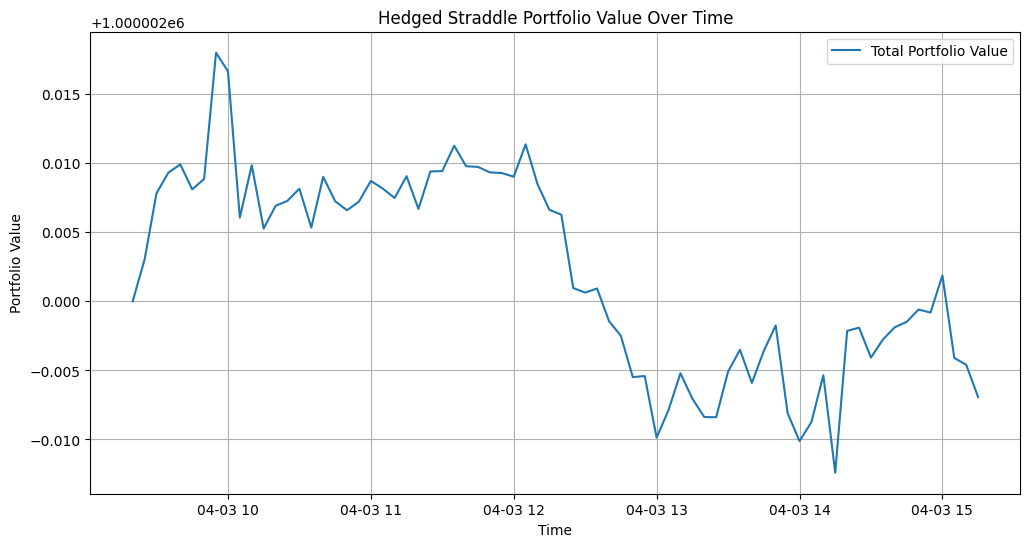

In [149]:
plt.figure(figsize=(12, 6))
plt.plot(pnl_df.index, pnl_df['TotalValue'], label='Total Portfolio Value')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.title('Hedged Straddle Portfolio Value Over Time')
plt.legend()
plt.grid(True)
plt.show()
